# Analysis of Autism Spectrum Disorder(ASD) related genetic data

This codes analyze the orgininal Autism Spectrum Disorder data of the paper "Long-term maturation of human cortical organoids matches key early postnatal transitions". We aims to understand the relationship between the column "genetic category" and three characteristics related to this gene: gene-score, number of reports, syndromic. To achieve this goal, we used machine learning methods of logistic regression and decision tree to determine which combinations of these three characteristics would be effective in predicting its genetic category.

Import necessary libraries

In [333]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree

Read in data and drop any incomplete data, preprocess the data by dropping irrelavent columns

In [326]:
asd=pd.read_csv("ASD.csv")
asd=asd.dropna()
asd=asd.drop(["status","gene-symbol","gene-name","ensembl-id"],axis=1)
asd

,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
1,17,Rare Single Gene Mutation,3.0,0,1
2,7,"Rare Single Gene Mutation, Functional",3.0,0,6
3,19,Rare Single Gene Mutation,3.0,0,4
4,17,"Rare Single Gene Mutation, Genetic Association",3.0,0,3
...,...,...,...,...,...
937,7,Rare Single Gene Mutation,3.0,0,2
938,15,Rare Single Gene Mutation,3.0,0,3
939,2,"Rare Single Gene Mutation, Genetic Association",2.0,0,13
940,4,Genetic Association,3.0,0,1


Preprocessing of genetic category strings

In [327]:
asd["genetic-category"]=asd["genetic-category"].str.split(",")
asd

,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,16,"[Rare Single Gene Mutation, Genetic Association]",3.0,0,5
1,17,[Rare Single Gene Mutation],3.0,0,1
2,7,"[Rare Single Gene Mutation, Functional]",3.0,0,6
3,19,[Rare Single Gene Mutation],3.0,0,4
4,17,"[Rare Single Gene Mutation, Genetic Association]",3.0,0,3
...,...,...,...,...,...
937,7,[Rare Single Gene Mutation],3.0,0,2
938,15,[Rare Single Gene Mutation],3.0,0,3
939,2,"[Rare Single Gene Mutation, Genetic Association]",2.0,0,13
940,4,[Genetic Association],3.0,0,1


Construct necessary lists for different types of mutations and chromosome catalogs

In [328]:
mutations=["Functional","Genetic Association","Rare Single Gene Mutation","Syndromic"]
chromosomes=[str(c) for c in range(1,23)]
chromosomes.append("X")
chromosomes.append("Y")
chromosomes.append("X,Y")
mutations,chromosomes

(['Functional',
  'Genetic Association',
  'Rare Single Gene Mutation',
  'Syndromic'],
 ['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  'X',
  'Y',
  'X,Y'])

Overall distribution of genetic categories

[Text(0.5, 0, 'Types of gene'),
 Text(0, 0.5, 'Incidences'),
 Text(0.5, 1.0, 'Occurences of different types of gene')]

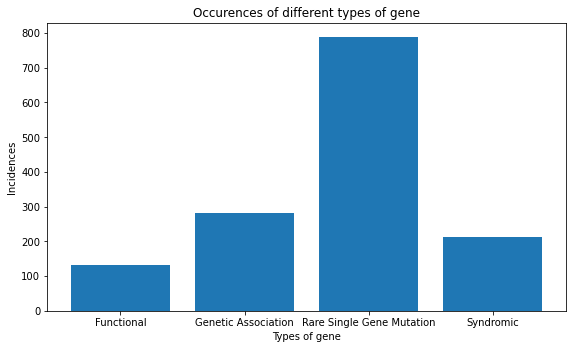

In [329]:
#count the number of incidences of each of the genetic category
count_Functional,count_Genetic_Association,count_Rare_Single_Gene_Mutation,count_Syndromic=0,0,0,0
for c in asd["genetic-category"]:
    for i in c:
        if i=="Functional" or i==" Functional":
            count_Functional+=1

for c in asd["genetic-category"]:
    for i in c:
        if i=="Genetic Association" or i==" Genetic Association":
            count_Genetic_Association+=1
            
for c in asd["genetic-category"]:
    for i in c:
        if i=="Rare Single Gene Mutation":
            count_Rare_Single_Gene_Mutation+=1

for c in asd["genetic-category"]:
    for i in c:
        if i=="Syndromic" or i==" Syndromic":
            count_Syndromic+=1

mutation_numbers=[count_Functional,count_Genetic_Association,count_Rare_Single_Gene_Mutation,count_Syndromic]

#plot the distribution of different genetic categories
fig = plt.figure()
ax = fig.add_axes([0,0,1.2,1])

ax.bar(mutations,mutation_numbers)
ax.set(xlabel="Types of gene",ylabel="Incidences", title="Occurences of different types of gene")

Display of the number of different genetic categories within each chromosomes

<ipython-input-330-80c62d0d94e3>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_axes([0,0,1.2,1])
<ipython-input-330-80c62d0d94e3>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


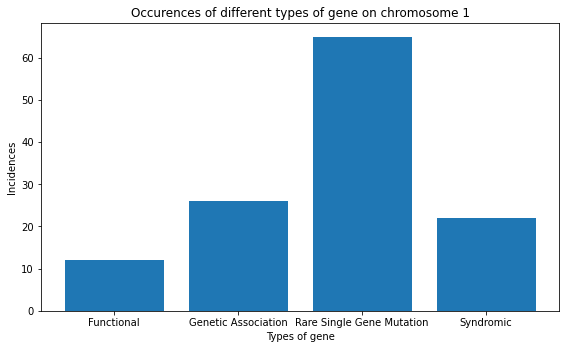

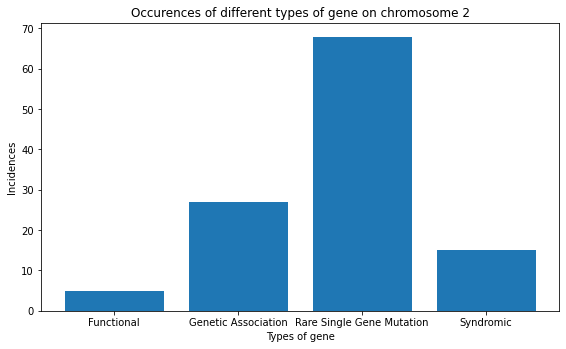

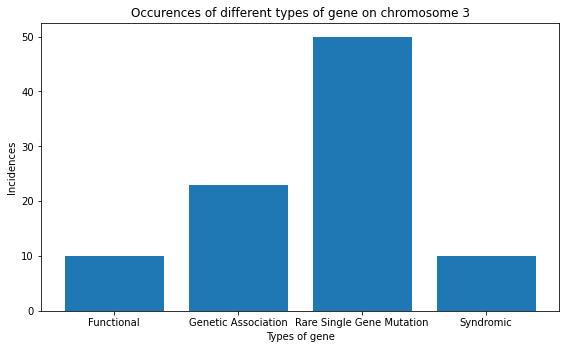

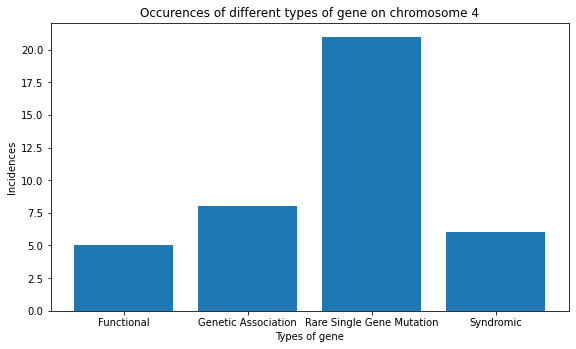

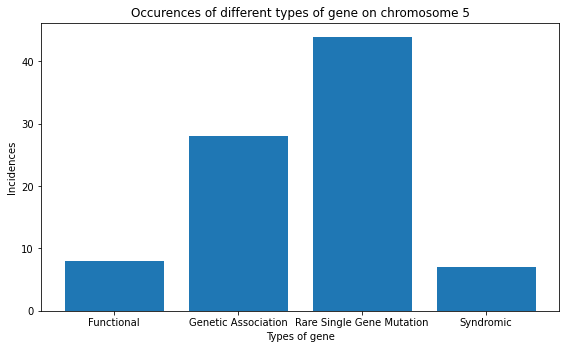

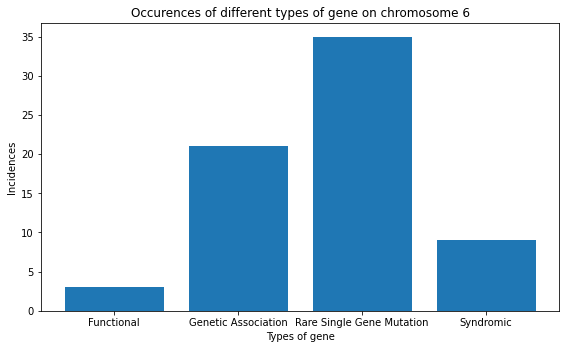

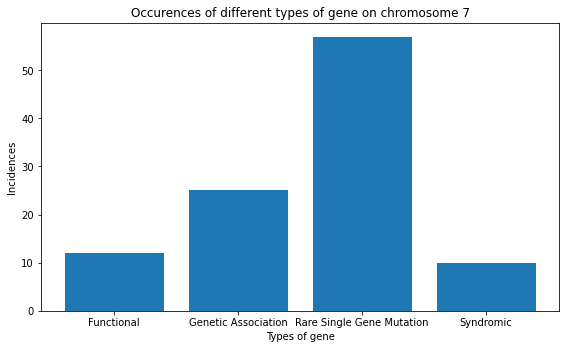

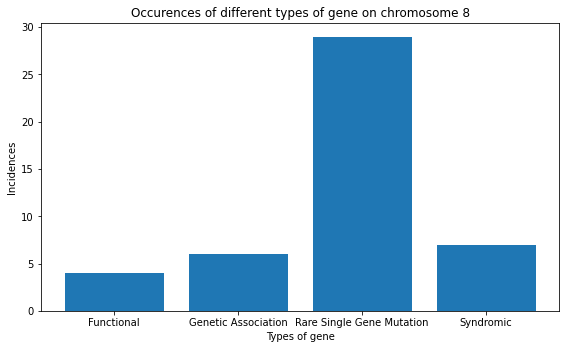

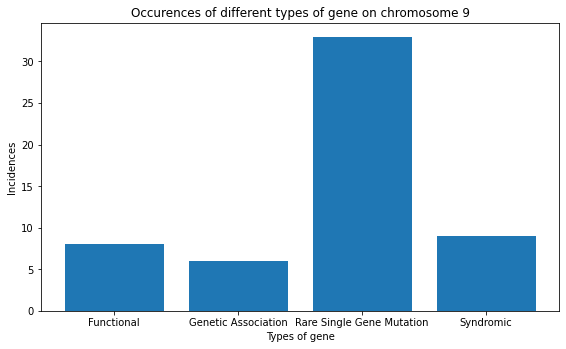

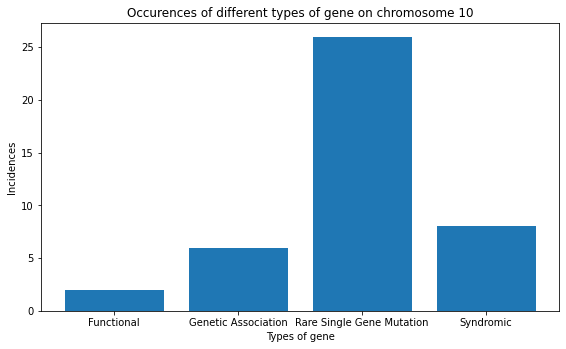

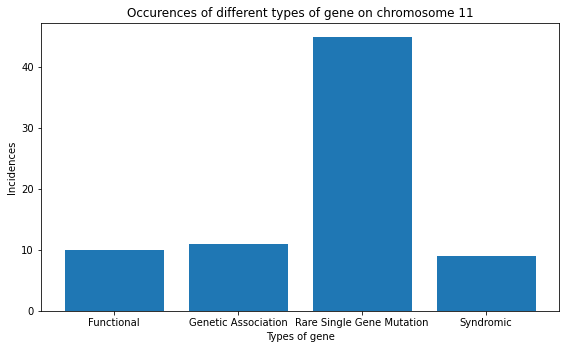

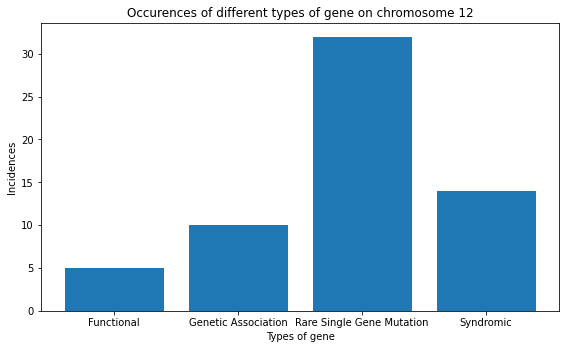

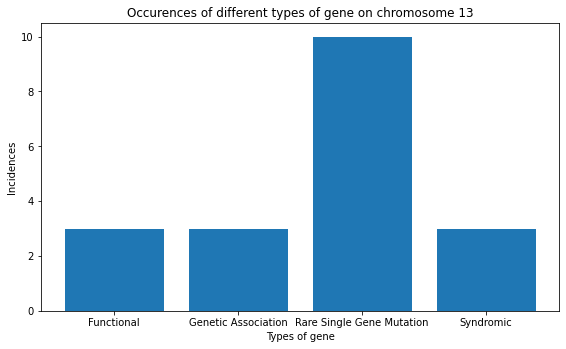

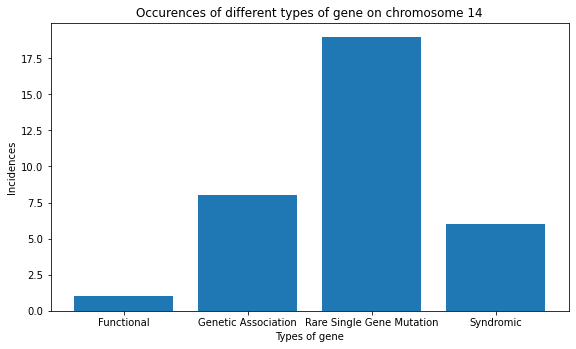

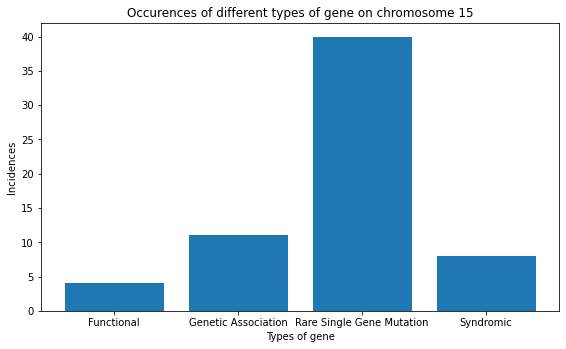

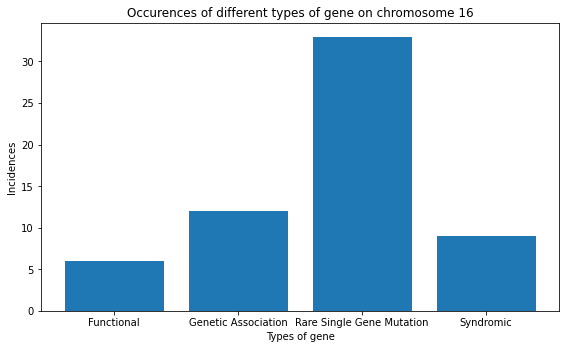

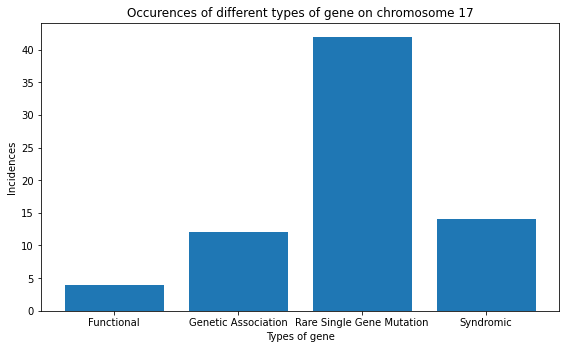

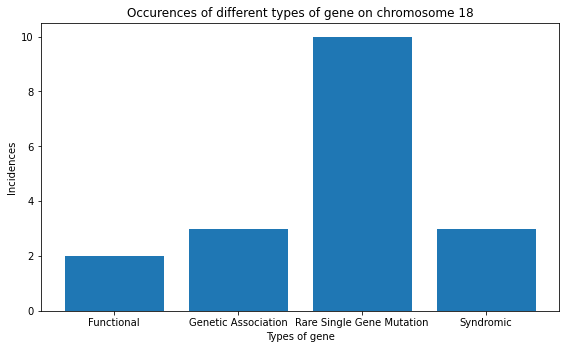

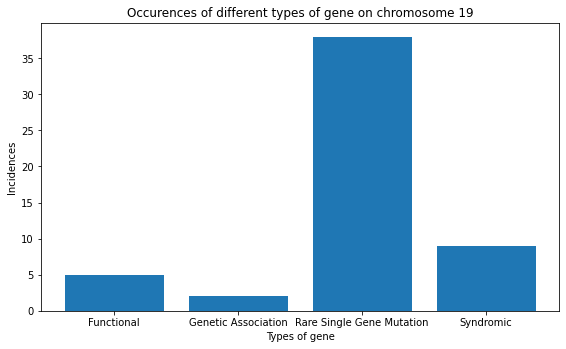

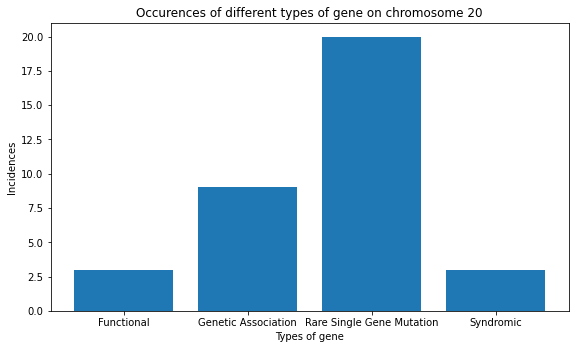

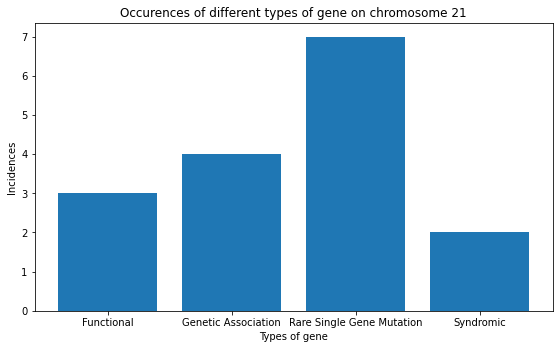

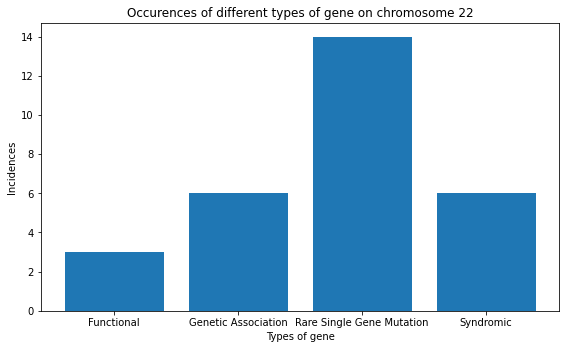

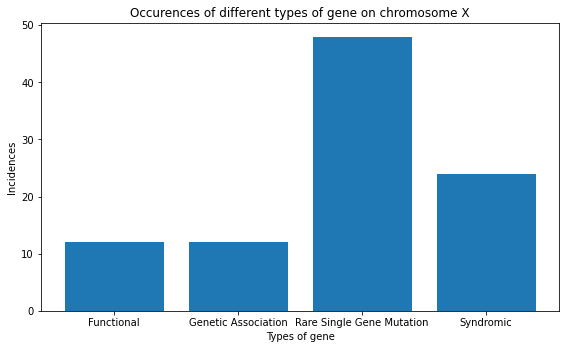

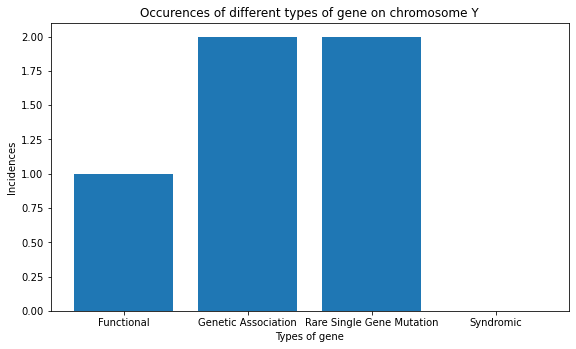

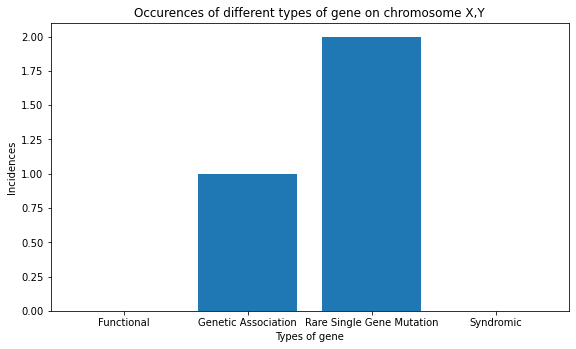

In [330]:
def plot(asd,ch):
    """This function take in the data frame asd and the list for chromosomes, then it counts the number of 
       incidences of each genetic category within each chromosomes, and plot the distribution of genetic 
       category for each chromosome"""
    
    c_asd=(asd[asd["chromosome"]==ch]).copy()
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1.2,1])
    
    #count the number of incidences of each of the genetic category for each chromosome
    count_Functional,count_Genetic_Association,count_Rare_Single_Gene_Mutation,count_Syndromic=0,0,0,0
    for c in c_asd["genetic-category"]:
        for i in c:
            if i=="Functional" or i==" Functional":
                count_Functional+=1

    for c in c_asd["genetic-category"]:
        for i in c:
            if i=="Genetic Association" or i==" Genetic Association":
                count_Genetic_Association+=1

    for c in c_asd["genetic-category"]:
        for i in c:
            if i=="Rare Single Gene Mutation":
                count_Rare_Single_Gene_Mutation+=1

    for c in c_asd["genetic-category"]:
        for i in c:
            if i=="Syndromic" or i==" Syndromic":
                count_Syndromic+=1

    mutation_numbers=[count_Functional,count_Genetic_Association,count_Rare_Single_Gene_Mutation,count_Syndromic]

    ax = fig.add_axes([0,0,1.2,1])
    
    ax.bar(mutations,mutation_numbers)
    
    ax.set(xlabel="Types of gene",ylabel="Incidences", 
           title="Occurences of different types of gene on chromosome "+str(ch))

        
for ch in chromosomes:
    plot(asd,ch)

Define the genetic category of a gene in four dimensions ("Functional","Genetic Association","Rare Single Gene Mutation","Syndromic"). If one gene satisfies one of the condition, marked as one, if not, marked as zero

In [198]:
asd["Functional"]=np.nan
for index,row in asd.iterrows():
    if row["genetic-category"].find("Functional")==0 or row["genetic-category"].find(" Functional")==-1:
        asd.at[index,"Functional"]=0
    else:
        asd.at[index,"Functional"]=1
            
asd["Genetic Association"]=np.nan
for index,row in asd.iterrows():
    if row["genetic-category"].find("Genetic Association")==0 or row["genetic-category"].find(" Genetic Association")==-1:
        asd.at[index,"Genetic Association"]=0
    else:
        asd.at[index,"Genetic Association"]=1
        
asd["Rare Single Gene Mutation"]=np.nan
for index,row in asd.iterrows():
    if row["genetic-category"].find("Rare Single Gene Mutation")==-1:
        asd.at[index,"Rare Single Gene Mutation"]=0
    else:
        asd.at[index,"Rare Single Gene Mutation"]=1

asd["Syndromic"]=np.nan
for index,row in asd.iterrows():
    if row["genetic-category"].find("Syndromic")==0 or row["genetic-category"].find(" Syndromic")==-1:
        asd.at[index,"Syndromic"]=0
    else:
        asd.at[index,"Syndromic"]=1
        
asd

,chromosome,genetic-category,gene-score,syndromic,number-of-reports,Functional,Genetic Association,Rare Single Gene Mutation,Syndromic
0,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5,0.0,1.0,1.0,0.0
1,17,Rare Single Gene Mutation,3.0,0,1,0.0,0.0,1.0,0.0
2,7,"Rare Single Gene Mutation, Functional",3.0,0,6,1.0,0.0,1.0,0.0
3,19,Rare Single Gene Mutation,3.0,0,4,0.0,0.0,1.0,0.0
4,17,"Rare Single Gene Mutation, Genetic Association",3.0,0,3,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
937,7,Rare Single Gene Mutation,3.0,0,2,0.0,0.0,1.0,0.0
938,15,Rare Single Gene Mutation,3.0,0,3,0.0,0.0,1.0,0.0
939,2,"Rare Single Gene Mutation, Genetic Association",2.0,0,13,0.0,1.0,1.0,0.0
940,4,Genetic Association,3.0,0,1,0.0,0.0,0.0,0.0


The primary two machine learning tools used in the analysis are logistic regression and decision trees. Cross validate with cv score of 5 (by which 4/5 of the data is selected as training data and 1/5 of the data is selected as test data).

Also, we use feature selection to determine which combination of "gene-score", "syndromic", and "number-of-reports" would be better in predicting the emergence of the four genetic categories( number of reports, functional, genetic association, rare single gene mutation, and syndromic).

# Part 1: Using logistic regression model to perform feature selection and cross-validation

1.1 Determining the category "functional"

1.1.1 Split the data and preprocess the test and train groups

In [231]:
#split data into training and test set, with test size size of 0.05
np.random.seed(1111)
train_LR_functional, test_LR_functional = train_test_split(asd, test_size = 0.05)

# data preprocessing
def prep_asd_data_functional(asd):
    """This function selects the independent variable as the columns without the inquired
     genetic category, and dependent variable as the column of the inquired genetic category, 
     in this sense, functional"""
    df = asd.copy()
    df = df.drop(['chromosome'], axis = 1)
    X = df.drop(['Functional'], axis = 1)
    y = df['Functional']
    return(X, y)

X_train_LR_functional, y_train_LR_functional = prep_asd_data_functional(train_LR_functional)
X_test_LR_functional,  y_test_LR_functional = prep_asd_data_functional(test_LR_functional)

1.1.2 Training

In [237]:
combos=[["gene-score"],["number-of-reports"],["syndromic"],
        ["gene-score","number-of-reports"],["gene-score","syndromic"],["number-of-reports","syndromic"],
        ["gene-score","number-of-reports","syndromic"]]

def check_column_scores_functional(cols):
    """trains and evaluates the model with cv and select combinations"""
    print("training with columns"+str(cols))

    LR=LogisticRegression()
    return cross_val_score(LR,X_train_LR_functional[cols],y_train_LR_functional,cv=20).mean()

for c in combos:
    x=check_column_scores_functional(c)
    print("CV score is "+str(np.round(x,3)))

training with columns['gene-score']
CV score is 0.853
training with columns['number-of-reports']
CV score is 0.857
training with columns['syndromic']
CV score is 0.853
training with columns['gene-score', 'number-of-reports']
CV score is 0.856
training with columns['gene-score', 'syndromic']
CV score is 0.853
training with columns['number-of-reports', 'syndromic']
CV score is 0.857
training with columns['gene-score', 'number-of-reports', 'syndromic']
CV score is 0.857


1.1.3 Testing

In [236]:
def test_column_score_functional(cols):
    """test model performance on the data ofselected columns"""
    print("training with columns"+str(cols))
    
    LR=LogisticRegression()
    LR.fit(X_test_LR_functional[cols],y_test_LR_functional)
    return LR.score(X_test_LR_functional[cols],y_test_LR_functional)

for c in combos:
    x=test_column_score_functional(c)
    print("the test score is "+str(np.round(x,3)))

training with columns['gene-score']
the test score is 0.818
training with columns['number-of-reports']
the test score is 0.841
training with columns['syndromic']
the test score is 0.818
training with columns['gene-score', 'number-of-reports']
the test score is 0.841
training with columns['gene-score', 'syndromic']
the test score is 0.818
training with columns['number-of-reports', 'syndromic']
the test score is 0.841
training with columns['gene-score', 'number-of-reports', 'syndromic']
the test score is 0.841


1.2 Determining the category "Genetic Association"

1.2.1 Split the data and preprocess the test and train groups

In [239]:
#split data into training and test set, with test size size of 0.05
np.random.seed(1111)
train_LR_GA, test_LR_GA = train_test_split(asd, test_size = 0.05)

# data preprocessing
def prep_asd_data_GA(asd):
    """This function selects the independent variable as the columns without the inquired
     genetic category, and dependent variable as the column of the inquired genetic category, 
     in this sense, genetic association"""
    df = asd.copy()
    df = df.drop(['chromosome'], axis = 1)
    X = df.drop(['Genetic Association'], axis = 1)
    y = df['Genetic Association']
    return(X, y)

X_train_LR_GA, y_train_LR_GA = prep_asd_data_GA(train_LR_GA)
X_test_LR_GA,  y_test_LR_GA = prep_asd_data_GA(test_LR_GA)

1.2.2 Training

In [240]:
combos=[["gene-score"],["number-of-reports"],["syndromic"],
        ["gene-score","number-of-reports"],["gene-score","syndromic"],["number-of-reports","syndromic"],
        ["gene-score","number-of-reports","syndromic"]]

def check_column_scores_GA(cols):
    """trains and evaluates the model with cv and select combinations"""
    print("training with columns"+str(cols))

    LR=LogisticRegression()
    return cross_val_score(LR,X_train_LR_GA[cols],y_train_LR_GA,cv=20).mean()

for c in combos:
    x=check_column_scores_GA(c)
    print("CV score is "+str(np.round(x,3)))

training with columns['gene-score']
CV score is 0.749
training with columns['number-of-reports']
CV score is 0.75
training with columns['syndromic']
CV score is 0.749
training with columns['gene-score', 'number-of-reports']
CV score is 0.763
training with columns['gene-score', 'syndromic']
CV score is 0.749
training with columns['number-of-reports', 'syndromic']
CV score is 0.75
training with columns['gene-score', 'number-of-reports', 'syndromic']
CV score is 0.759


1.2.3 Testing

In [241]:
def test_column_score_GA(cols):
    """test model performance on the data ofselected columns"""
    print("training with columns"+str(cols))
    
    LR=LogisticRegression()
    LR.fit(X_test_LR_GA[cols],y_test_LR_GA)
    return LR.score(X_test_LR_GA[cols],y_test_LR_GA)

for c in combos:
    x=test_column_score_GA(c)
    print("the test score is "+str(np.round(x,3)))

training with columns['gene-score']
the test score is 0.614
training with columns['number-of-reports']
the test score is 0.636
training with columns['syndromic']
the test score is 0.614
training with columns['gene-score', 'number-of-reports']
the test score is 0.659
training with columns['gene-score', 'syndromic']
the test score is 0.614
training with columns['number-of-reports', 'syndromic']
the test score is 0.636
training with columns['gene-score', 'number-of-reports', 'syndromic']
the test score is 0.659


1.3 Determining the category "Rare Single Gene Mutation"

1.3.1 Split the data and preprocess the test and train groups

In [257]:
#split data into training and test set, with test size size of 0.05
np.random.seed(1111)
train_LR_RSGM, test_LR_RSGM = train_test_split(asd, test_size = 0.05)

# data preprocessing
def prep_asd_data_RSGM(asd):
    """This function selects the independent variable as the columns without the inquired
     genetic category, and dependent variable as the column of the inquired genetic category, 
     in this sense, rare single gene mutataion"""
    df = asd.copy()
    df = df.drop(['chromosome'], axis = 1)
    X = df.drop(['Rare Single Gene Mutation'], axis = 1)
    y = df['Rare Single Gene Mutation']
    return(X, y)

X_train_LR_RSGM, y_train_LR_RSGM = prep_asd_data_RSGM(train_LR_RSGM)
X_test_LR_RSGM,  y_test_LR_RSGM = prep_asd_data_RSGM(test_LR_RSGM)

1.3.2 Training

In [258]:
combos=[["gene-score"],["number-of-reports"],["syndromic"],
        ["gene-score","number-of-reports"],["gene-score","syndromic"],["number-of-reports","syndromic"],
        ["gene-score","number-of-reports","syndromic"]]

def check_column_scores_RSGM(cols):
    """trains and evaluates the model with cv and select combinations"""
    print("training with columns"+str(cols))

    LR=LogisticRegression()
    return cross_val_score(LR,X_train_LR_RSGM[cols],y_train_LR_RSGM,cv=20).mean()

for c in combos:
    x=check_column_scores_RSGM(c)
    print("CV score is "+str(np.round(x,3)))

training with columns['gene-score']
CV score is 0.922
training with columns['number-of-reports']
CV score is 0.922
training with columns['syndromic']
CV score is 0.922
training with columns['gene-score', 'number-of-reports']
CV score is 0.922
training with columns['gene-score', 'syndromic']
CV score is 0.922
training with columns['number-of-reports', 'syndromic']
CV score is 0.922
training with columns['gene-score', 'number-of-reports', 'syndromic']
CV score is 0.922


1.3.3 Testing

In [259]:
def test_column_score_RSGM(cols):
    """test model performance on the data ofselected columns"""
    print("training with columns"+str(cols))
    
    LR=LogisticRegression()
    LR.fit(X_test_LR_RSGM[cols],y_test_LR_RSGM)
    return LR.score(X_test_LR_RSGM[cols],y_test_LR_RSGM)

for c in combos:
    x=test_column_score_RSGM(c)
    print("the test score is "+str(np.round(x,3)))

training with columns['gene-score']
the test score is 0.841
training with columns['number-of-reports']
the test score is 0.841
training with columns['syndromic']
the test score is 0.841
training with columns['gene-score', 'number-of-reports']
the test score is 0.841
training with columns['gene-score', 'syndromic']
the test score is 0.841
training with columns['number-of-reports', 'syndromic']
the test score is 0.841
training with columns['gene-score', 'number-of-reports', 'syndromic']
the test score is 0.841


1.4 Determining the category "Syndromic"

1.4.1 Split the data and preprocess the test and train groups

In [314]:
#split data into training and test set, with test size size of 0.05
np.random.seed(1111)
train_LR_Syndromic, test_LR_Syndromic = train_test_split(asd, test_size = 0.05)

# data preprocessing
def prep_asd_data_Syndromic(asd):
    """This function selects the independent variable as the columns without the inquired
     genetic category, and dependent variable as the column of the inquired genetic category, 
     in this sense, syndromic"""
    df = asd.copy()
    df = df.drop(['chromosome'], axis = 1)
    X = df.drop(['Syndromic'], axis = 1)
    y = df['Syndromic']
    return(X, y)

X_train_LR_Syndromic, y_train_LR_Syndromic = prep_asd_data_Syndromic(train_LR_Syndromic)
X_test_LR_Syndromic,  y_test_LR_Syndromic = prep_asd_data_Syndromic(test_LR_Syndromic)

1.4.2 Training

In [315]:
combos=[["gene-score"],["number-of-reports"],["syndromic"],
        ["gene-score","number-of-reports"],["gene-score","syndromic"],["number-of-reports","syndromic"],
        ["gene-score","number-of-reports","syndromic"]]

def check_column_scores_Syndromic(cols):
    """trains and evaluates the model with cv and select combinations"""
    print("training with columns"+str(cols))

    LR=LogisticRegression()
    return cross_val_score(LR,X_train_LR_Syndromic[cols],y_train_LR_Syndromic,cv=20).mean()

for c in combos:
    x=check_column_scores_Syndromic(c)
    print("CV score is "+str(np.round(x,3)))

training with columns['gene-score']
CV score is 0.824
training with columns['number-of-reports']
CV score is 0.821
training with columns['syndromic']
CV score is 0.793
training with columns['gene-score', 'number-of-reports']
CV score is 0.847
training with columns['gene-score', 'syndromic']
CV score is 0.859
training with columns['number-of-reports', 'syndromic']
CV score is 0.851
training with columns['gene-score', 'number-of-reports', 'syndromic']
CV score is 0.885


1.4.3 Testing

In [316]:
def test_column_score_Syndromic(cols):
    """test model performance on the data ofselected columns"""
    print("training with columns"+str(cols))
    
    LR=LogisticRegression()
    LR.fit(X_test_LR_Syndromic[cols],y_test_LR_Syndromic)
    return LR.score(X_test_LR_Syndromic[cols],y_test_LR_Syndromic)

for c in combos:
    x=test_column_score_Syndromic(c)
    print("the test score is "+str(np.round(x,3)))

training with columns['gene-score']
the test score is 0.841
training with columns['number-of-reports']
the test score is 0.841
training with columns['syndromic']
the test score is 0.841
training with columns['gene-score', 'number-of-reports']
the test score is 0.864
training with columns['gene-score', 'syndromic']
the test score is 0.841
training with columns['number-of-reports', 'syndromic']
the test score is 0.841
training with columns['gene-score', 'number-of-reports', 'syndromic']
the test score is 0.886


# Part 2: Using decision tree model to perform feature selection and cross-validation

2.1 Determining the category "functional"

In [321]:
X_train_DT_functional, y_train_DT_functional = prep_asd_data_functional(train_LR_functional)
X_test_DT_functional,  y_test_DT_functional = prep_asd_data_functional(test_LR_functional)

for c in combos:
    
    N=20
    score=np.zeros(N)
    best_score_f=-np.inf
    
    for d in range(1,N+1):
        T=tree.DecisionTreeClassifier(max_depth=d)
        #record the mean cross validation score of a particular depth in the array
        score[d-1]=cross_val_score(T,X_train_DT_functional[c],y_train_DT_functional,cv=20).mean()

        #update the best score so far
        if score[d-1]>best_score_f:
            best_score_f=np.round(score[d-1],3)
            best_depth_f=np.round(d,3)
    
    #display train score and best maximum decision tree depth
    print("The mean cv score of group "+ str(c)+" is "+str(best_score_f) +
          " with the best-performed maximum depth of "+ str(best_depth_f))
    
    #display test score
    T_test=tree.DecisionTreeClassifier(max_depth=best_depth_f)
    test_score=cross_val_score(T,X_test_DT_functional[c],y_test_DT_functional,cv=7).mean()
    print("Using test data, its score is "+ str(np.round(test_score,3)))

The mean cv score of group ['gene-score'] is 0.853 with the best-performed maximum depth of 20
Using test data, its score is 0.82
The mean cv score of group ['number-of-reports'] is 0.858 with the best-performed maximum depth of 4
Using test data, its score is 0.793
The mean cv score of group ['syndromic'] is 0.853 with the best-performed maximum depth of 20
Using test data, its score is 0.799
The mean cv score of group ['gene-score', 'number-of-reports'] is 0.858 with the best-performed maximum depth of 4
Using test data, its score is 0.704
The mean cv score of group ['gene-score', 'syndromic'] is 0.853 with the best-performed maximum depth of 20
Using test data, its score is 0.799
The mean cv score of group ['number-of-reports', 'syndromic'] is 0.858 with the best-performed maximum depth of 4
Using test data, its score is 0.793
The mean cv score of group ['gene-score', 'number-of-reports', 'syndromic'] is 0.858 with the best-performed maximum depth of 4
Using test data, its score is 

2.2 Determining the category "Genetic Association"

In [319]:
X_train_DT_GA, y_train_DT_GA = prep_asd_data_GA(train_LR_GA)
X_test_DT_GA,  y_test_DT_GA = prep_asd_data_GA(test_LR_GA)

for c in combos:
    
    N=20
    score=np.zeros(N)
    best_score_GA=-np.inf
    
    for d in range(1,N+1):
        T=tree.DecisionTreeClassifier(max_depth=d)
        #record the mean cross validation score of a particular depth in the array
        score[d-1]=cross_val_score(T,X_train_DT_GA[c],y_train_DT_GA,cv=20).mean()

        #update the best score so far
        if score[d-1]>best_score_GA:
            best_score_GA=np.round(score[d-1],3)
            best_depth_GA=np.round(d,3)
    
     #display train score and best maximum decision tree depth
    print("The mean cv score of group "+ str(c)+" is "+str(best_score_GA) +
          " with the best-performed maximum depth of "+ str(best_depth_GA))
    
    #display test score
    T_test=tree.DecisionTreeClassifier(max_depth=best_depth_GA)
    test_score=cross_val_score(T,X_test_DT_GA[c],y_test_DT_GA,cv=7).mean()
    print("Using test data, its score is "+ str(np.round(test_score,3)))

The mean cv score of group ['gene-score'] is 0.749 with the best-performed maximum depth of 20
Using test data, its score is 0.616
The mean cv score of group ['number-of-reports'] is 0.752 with the best-performed maximum depth of 2
Using test data, its score is 0.612
The mean cv score of group ['syndromic'] is 0.749 with the best-performed maximum depth of 20
Using test data, its score is 0.595
The mean cv score of group ['gene-score', 'number-of-reports'] is 0.759 with the best-performed maximum depth of 4
Using test data, its score is 0.616
The mean cv score of group ['gene-score', 'syndromic'] is 0.749 with the best-performed maximum depth of 20
Using test data, its score is 0.595
The mean cv score of group ['number-of-reports', 'syndromic'] is 0.752 with the best-performed maximum depth of 2
Using test data, its score is 0.612
The mean cv score of group ['gene-score', 'number-of-reports', 'syndromic'] is 0.763 with the best-performed maximum depth of 5
Using test data, its score is

2.3 Determining the category "Rare Single Gene Mutation"

In [318]:
X_train_DT_RSGM, y_train_DT_RSGM = prep_asd_data_RSGM(train_LR_RSGM)
X_test_DT_RSGM,  y_test_DT_RSGM = prep_asd_data_RSGM(test_LR_RSGM)

for c in combos:
    
    N=20
    score=np.zeros(N)
    best_score_RSGM=-np.inf
    
    for d in range(1,N+1):
        T=tree.DecisionTreeClassifier(max_depth=d)
        #record the mean cross validation score of a particular depth in the array
        score[d-1]=cross_val_score(T,X_train_DT_RSGM[c],y_train_DT_RSGM,cv=20).mean()

        #update the best score so far
        if score[d-1]>best_score_RSGM:
            best_score_RSGM=np.round(score[d-1],3)
            best_depth_RSGM=np.round(d,3)
    
    #display train score and best maximum decision tree depth
    print("The mean cv score of group "+ str(c)+" is "+str(best_score_RSGM) +
          " with the best-performed maximum depth of "+ str(best_depth_RSGM))
    
    #display test score
    T_test=tree.DecisionTreeClassifier(max_depth=best_depth_RSGM)
    test_score=cross_val_score(T,X_test_DT_RSGM[c],y_test_DT_RSGM,cv=7).mean()
    print("Using test data, its score is "+ str(np.round(test_score,3)))

The mean cv score of group ['gene-score'] is 0.922 with the best-performed maximum depth of 1
Using test data, its score is 0.84
The mean cv score of group ['number-of-reports'] is 0.922 with the best-performed maximum depth of 1
Using test data, its score is 0.796
The mean cv score of group ['syndromic'] is 0.922 with the best-performed maximum depth of 1
Using test data, its score is 0.84
The mean cv score of group ['gene-score', 'number-of-reports'] is 0.924 with the best-performed maximum depth of 4
Using test data, its score is 0.707
The mean cv score of group ['gene-score', 'syndromic'] is 0.922 with the best-performed maximum depth of 1
Using test data, its score is 0.84
The mean cv score of group ['number-of-reports', 'syndromic'] is 0.922 with the best-performed maximum depth of 1
Using test data, its score is 0.796
The mean cv score of group ['gene-score', 'number-of-reports', 'syndromic'] is 0.924 with the best-performed maximum depth of 4
Using test data, its score is 0.707

2.4 Determining the category "Syndromic"

In [317]:
X_train_DT_Syndromic, y_train_DT_Syndromic = prep_asd_data_Syndromic(train_LR_Syndromic)
X_test_DT_Syndromic,  y_test_DT_Syndromic = prep_asd_data_Syndromic(test_LR_Syndromic)

for c in combos:
    
    N=20
    score=np.zeros(N)
    best_score_Syndromic=-np.inf
    
    for d in range(1,N+1):
        T=tree.DecisionTreeClassifier(max_depth=d)
        #record the mean cross validation score of a particular depth in the array
        score[d-1]=cross_val_score(T,X_train_DT_Syndromic[c],y_train_DT_Syndromic,cv=10).mean()

        #update the best score so far
        if score[d-1]>best_score_Syndromic:
            best_score_Syndromic=np.round(score[d-1],3)
            best_depth_Syndromic=np.round(d,3)
    
    #display train score and best maximum decision tree depth
    print("The mean cv score of group "+ str(c)+" is "+str(best_score_Syndromic) +
          " with the best-performed maximum depth of "+ str(best_depth_Syndromic))
    
    #display test score
    T_test=tree.DecisionTreeClassifier(max_depth=best_depth_Syndromic)
    test_score=cross_val_score(T,X_test_DT_Syndromic[c],y_test_DT_Syndromic,cv=7).mean()
    print("Using test data, its score is "+ str(np.round(test_score,3)))

The mean cv score of group ['gene-score'] is 0.824 with the best-performed maximum depth of 1
Using test data, its score is 0.772
The mean cv score of group ['number-of-reports'] is 0.831 with the best-performed maximum depth of 3
Using test data, its score is 0.799
The mean cv score of group ['syndromic'] is 0.793 with the best-performed maximum depth of 20
Using test data, its score is 0.884
The mean cv score of group ['gene-score', 'number-of-reports'] is 0.848 with the best-performed maximum depth of 3
Using test data, its score is 0.823
The mean cv score of group ['gene-score', 'syndromic'] is 0.859 with the best-performed maximum depth of 20
Using test data, its score is 0.816
The mean cv score of group ['number-of-reports', 'syndromic'] is 0.857 with the best-performed maximum depth of 3
Using test data, its score is 0.776
The mean cv score of group ['gene-score', 'number-of-reports', 'syndromic'] is 0.881 with the best-performed maximum depth of 3
Using test data, its score is 

# Part 3: Analysis

At this point, with the help of logistic regression and decision tree method, we have obtained the train score and test score of predicting the genetic category using one of more parameters of the following: gene-score, number of reports, and syndromic. Then, we will analyze which model has a better performance in predicting each of the four categories.

1. Functional

In the logistic regression model, the combinations ['gene-score', 'number-of-reports', 'syndromic'],[ 'number-of-reports', 'syndromic'],['gene-score', 'number-of-reports'], and ['number-of-reports'] has both the train score and the test score highest among all 7 combinations(Train score: 0.857, test score:0.841). Nevertheless, all of the groups involve the parameter "number of reports". Nevertheless, in the decision tree model, the similar relative better performance of combinations including "number of reports" is preserved only in the training scores, with these four groups being the highest of 0.858. And overfitting case emerges in groups of ['gene-score', 'number-of-reports', 'syndromic'],[ 'number-of-reports', 'syndromic'],['gene-score', 'number-of-reports'], as demonstrated by their test score much lower than 0.858 and their best maximal depth being 20.

Hence, we can conclude that using linear regression models, using the values of number of reports for a gene could be predictive for functional characteristics. Using decision tree models will achieve similar training performances for groups with "number-of-reports", but overfitting emerges and exacerbates in groups except for the combo with "number-of-reports" along.

2. Genetic Association

Using logistic regression model, the combination ['gene-score', 'number-of-reports'] has the highest train score of 0.763, and the test performance is best observed in the groups ['gene-score', 'number-of-reports'] and ['gene-score', 'number-of-reports','syndromic']. Using decision tree model, the best train score is observed in the group ['gene-score', 'number-of-reports','syndromic'], and test performances are equally best in ['gene-score', 'number-of-reports'], ['gene-score'], and ['gene-score', 'number-of-reports', 'syndromic']. This shows that gene-score is involved with the aspects of genetic association property, but the predictive power is not as strong in the "Functional" group, since using the two model we only obtain the test scores in the range of 0.7-0.82 and test performance around 0.6.

3. Rare Single Gene Mutation

Though well performed in terms of train and test score using logistic regression model, feature selection failed in this sense since there is no distinguishment in performance between each of the combinations. Using the Decision tree model, the train performance is best using groups ['gene-score', 'number-of-reports'] and ['gene-score', 'number-of-reports','syndromic'], with train score of 0.924. And train scores if other combinations remain to be relatively high at 0.922. Nevertheless, in the test groups, we observed a low test scores in the groups ['gene-score', 'number-of-reports'] and ['gene-score', 'number-of-reports','syndromic'], and the test performance was the highest using groups [ 'syndromic'], ['gene-score', 'syndromic'], and ['gene-score'] with test scores of 0.84. 

Hence, we concluded that using logistic regression models fail to select distinguished feature in predicting the category "Rare single gene mutation", though maitaining a high performance scores in both the train and test groups. Comprehensively, using decision tree model and after comprehensively evaluated, feature selection found groups [ 'syndromic'], ['gene-score', 'syndromic'], and ['gene-score'] have better performance in predicting the characteristics "Rare Single Gene Mutation".

4. Syndromic

Using logistic regression model, the training and testing performance is the best in the group ['gene-score', 'number-of-reports','syndromic']. Using decision tree model, the train score is the highest in the same group, but when we inspect the test scores of each combinations, overfitting emerges in the combination ["syndromic"], demonstrated by its very large maximum depth (N=20), and its higher-than-train-score test scores. Hence, in general, using all three parameters ['gene-score', 'number-of-reports','syndromic'] would be predictive for the "syndromic" category of the gene, either in logistic regression or decision tree model.

